#Anomaly detection using Autoencoder (PyTorch)

## Install requirements

In [1]:
%pip install tsne-torch


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
! pip install kaggle

## Import libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import re
from PIL import Image
from sklearn.manifold import TSNE
import numpy as np

## Load data

In [4]:
! mkdir ~/.kaggle

mkdir: /Users/nguyenphan/.kaggle: File exists


In [5]:
cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
^C


In [ ]:
! unzip new-plant-diseases-dataset.zip

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## ِ Visualize data

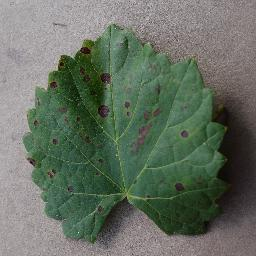

In [11]:
img = Image.open('/Users/nguyenphan/Developer/Leaf-Anomaly-Detection/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Grape___Black_rot/006efc68-9e46-4168-921c-10ef8065702c___FAM_B.Rot 3470.JPG')
img

## Building train set

In [12]:
train_path = "/Users/nguyenphan/Developer/Leaf-Anomaly-Detection/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"

In [13]:
def get_label(name):
  label = 0
  if bool(re.match('Grape___E.+', name)):
    label = 1
  elif bool(re.match('Grape___L.+', name)):
    label = 2
  elif bool(re.match('Grape___h.+', name)):
    label = 3
  return label
    

In [14]:
convert_tensor = transforms.ToTensor()
train_data = []
for root, dirs, files in os.walk(train_path):
  class_name = root.split('/')[-1]
  if bool(re.match('Grape.+', class_name)):
    for file in files:
      path = os.path.join(root, file)
      img = Image.open(path)
      tensor_img = convert_tensor(img)
      tensor_img = tensor_img.to(device)
      label = get_label(class_name)
      train_data.append([tensor_img, label])

print(len(train_data))

7222


In [15]:
train_data[0][0].is_cuda

False

In [16]:
train_loader = torch.utils.data.DataLoader(
    dataset= train_data,
    batch_size=16
)

In [ ]:
# train_iter = iter(train_loader)
# train_images, train_labels = train_iter.next()
# print(train_images.shape, '  ', train_labels.shape)

In [ ]:
# print(torch.min(train_images), torch.max(train_images))

## Building Model

In [17]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=7, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=7, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=5)
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=5),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=7, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, kernel_size=7, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3, kernel_size=7, stride=2, padding=1, output_padding=1),
        nn.Sigmoid() # As we saw that the input tensors are between 0 and 1 so we should use an activation function to map our values to that range.
    )
    

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [ ]:
model = Autoencoder()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
num_epochs = 20
# outputs = []
for epoch in range(num_epochs):
    for (img, _) in train_loader:
      recon = model(img)
      loss = criterion(recon, img)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    # outputs.append((epoch, img, recon))
  

Epoch:1, Loss:0.0078
Epoch:2, Loss:0.0063
Epoch:3, Loss:0.0060
Epoch:4, Loss:0.0055
Epoch:5, Loss:0.0052
Epoch:6, Loss:0.0049
Epoch:7, Loss:0.0049
Epoch:8, Loss:0.0046
Epoch:9, Loss:0.0045
Epoch:10, Loss:0.0044
Epoch:11, Loss:0.0043
Epoch:12, Loss:0.0043
Epoch:13, Loss:0.0043
Epoch:14, Loss:0.0042
Epoch:15, Loss:0.0060
Epoch:16, Loss:0.0051
Epoch:17, Loss:0.0048
Epoch:18, Loss:0.0046
Epoch:19, Loss:0.0045
Epoch:20, Loss:0.0044


## Building test set

In [ ]:
test_path = "/content/test/test"

In [ ]:
convert_tensor = transforms.ToTensor()
test_data = []
test_label = []
for root, dirs, files in os.walk(test_path):
    for file in files:
      path = os.path.join(root, file)
      img = Image.open(path)
      tensor_img = convert_tensor(img)
      tensor_img = tensor_img.to(device)
      test_data.append([tensor_img, 4])
      test_label.append('Anomaly')

print(len(test_data))

33


In [ ]:
test_data = test_data[:28]
test_label = test_label[:28]

adding un-anomaly data to test set:

In [ ]:
val_path = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [ ]:
count = [0 for i in range(4)]

for root, dirs, files in os.walk(val_path):
  class_name = root.split('/')[-1]
  if bool(re.match('Grape.+', class_name)):
    for file in files:
      label = get_label(class_name)
      count[label] += 1
      if count[label] >= 18:
        break
      path = os.path.join(root, file)
      img = Image.open(path)
      tensor_img = convert_tensor(img)
      tensor_img = tensor_img.to(device)
      test_data.append([tensor_img, label])
      test_label.append(label)


print(len(test_data))

96


In [ ]:
test_data[0][0].is_cuda

True

In [ ]:
test_loader = torch.utils.data.DataLoader(
    dataset= test_data,
    batch_size=8,
    shuffle=False
)

## Test model

In [ ]:
torch.cuda.empty_cache() 

In [ ]:
encodes = []

for (img, _) in test_loader:
  code = model.encoder(img)
  encodes.append(torch.tensor(code, device = 'cpu'))
  
len(encodes)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


12

In [ ]:
[t.shape for t in encodes]

[torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25]),
 torch.Size([8, 128, 25, 25])]

In [ ]:
y = []
tsne = TSNE()
for t in encodes:
  x = t.reshape(8, -1)
  embd = tsne.fit_transform(x)
  y.append(embd)

len(y)

12

In [ ]:
y[7]

array([[-13.042469,  26.275818],
       [-20.698936,  25.58869 ],
       [-11.949776,  33.879375],
       [ -6.545726,  30.223011],
       [ -5.953854,  23.477936],
       [-17.401628,  19.803759],
       [-18.627954,  31.843233],
       [-10.703817,  18.989464]], dtype=float32)

In [ ]:
x = []
for i in range(len(y)):
  for j in y[i]:
    x.append(j)

len(x)

96

In [ ]:
# ttt = np.array(x)
# list(map(lambda i : i[0], x))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


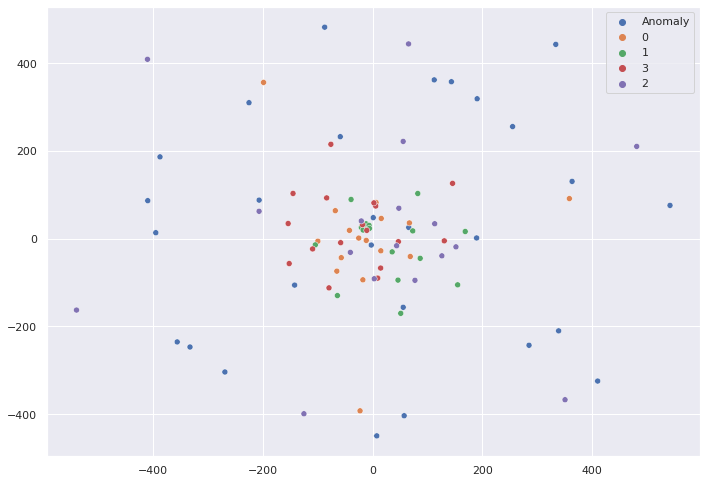

In [ ]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(list(map(lambda i : i[0], x)), list(map(lambda i : i[1], x)), hue=test_label)